In [7]:
using ProgressMeter, IndexedGraphs, Graphs
using MatrixProductBP, MatrixProductBP.Models

λ = 0.1

γ = 0.9      # prob. of zero patient
ρ = 0.1       # rate of recovery
α = 0.0

k = 3
T = 10^7

N = 2000
Δt = 1.0
seed = 0
gg = random_regular_graph(N, k; seed)
g = IndexedGraph(gg)

P0 = fill(γ, N)
K = ceil(Int, T/Δt)+1


function getstats(Δt, K)
    p = Progress(K; dt=1)
    ni = zeros(Int, K)

    function stats(t, i, x)
        k = ceil(Int, t/Δt)
        update!(p, k)
        ni[k + 1] += 2x[i]-1
    end
end

stat = getstats(Δt, K)

simulate_queue_sis!(falses(N), g, P0, λ, ρ, α, T; stats=stat);

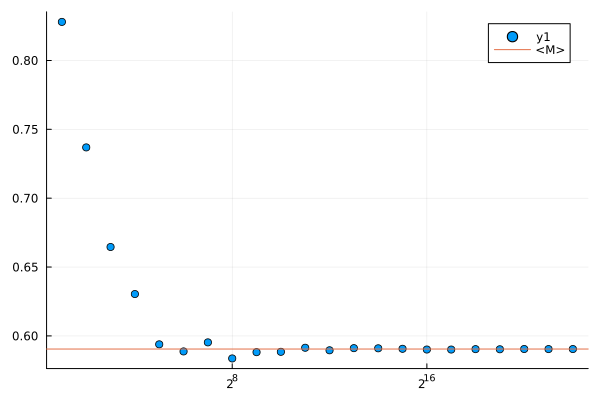

In [20]:
X = cumsum(stat.ni) ./ N

function blockmean(X)
    N = length(X)
    @showprogress map(1:floor(Int, log2(N))-1) do i 
        @views sum(X[2^i:2^(i+1)-1])/2^i
    end
end

therm = blockmean(X)

using Plots

scatter(2 .^ eachindex(therm), therm, xscale=:log2)
pl= hline!([sum(X[end÷2:end])/length(X[end÷2:end])], label="<M>")

In [22]:
therm

22-element Vector{Float64}:
 0.8280000000000001
 0.736875
 0.6645625
 0.63040625
 0.5938906250000001
 0.5887421875000001
 0.5953164062500002
 0.583646484375
 0.588203125
 0.5884565429687499
 ⋮
 0.5910102233886718
 0.5906504516601563
 0.590121482849121
 0.5901059684753418
 0.5904024505615235
 0.5903037261962891
 0.5904984002113343
 0.5904391305446625
 0.5904718520641328

In [39]:
dts = 1:5:200
M = @view X[end÷2:end]
M2 = sum(x->x^2, M)/length(M)
M1 = sum(M)/length(M)
corr = map(dts) do dt
    n = length(M)-dt
    Mtdt = @views sum(M[dt+1:end])/n
    Mt = @views sum(M[1:end-dt])/n
    C = @inbounds sum((M[t+dt]-Mtdt)*(M[t]-Mt)/n for t=1:n)
    C/(M2-M1^2)
end;

InterruptException: InterruptException:

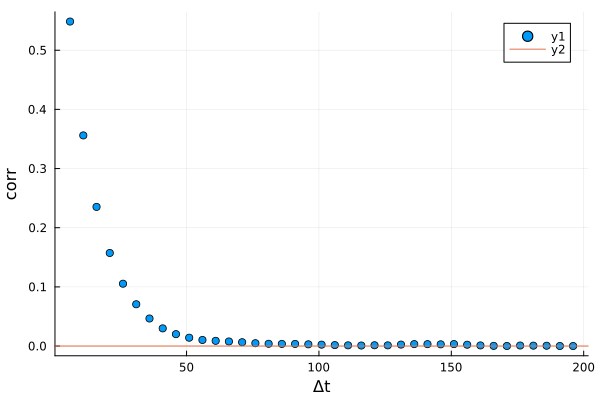

In [46]:
scatter(dts[2:40], abs.(corr[2:40]), xlabel="Δt", ylabel="corr")
hline!([0])

In [30]:
# decorrelation time is determined by looking at the plots above
decorrelation_time = 80

M1, √(M2-M1^2)/√(length(M)/decorrelation_time)

(0.590493197502721, 6.281927060550047e-5)